In [1]:
%pylab inline
from IPython.display import Audio
import numpy as np
from scipy import signal
from scipy import fftpack
from proto import enframe,preemp,windowing,powerSpectrum,logMelSpectrum,cepstrum
from tools import trfbank,lifter

Populating the interactive namespace from numpy and matplotlib


In [2]:
example = np.load('lab1_example.npz')['example'].item()

In [3]:
SAMPLING_RATE = example['samplingrate']
PREEMCOEFF = 0.97
NFFT = 512
NCEPS = 13
LIFTERCOEFF = 22
WINDOW_LEN = int(20e-3 * SAMPLING_RATE) # 20ms
WINDOW_SHIFT = int(10e-3 * SAMPLING_RATE) # 10ms

In [4]:
Audio(example['samples'],rate = SAMPLING_RATE)

## Whole process & Correctness check

In [6]:
frames = enframe(example['samples'],WINDOW_LEN,WINDOW_SHIFT)
preemph = preemp(frames,PREEMCOEFF)
windowed = windowing(preemph)
spec = powerSpectrum(windowed,NFFT)
mspec = logMelSpectrum(spec,SAMPLING_RATE)
ceps = cepstrum(mspec,NCEPS)
lifted_ceps = lifter(ceps,LIFTERCOEFF)

print(np.array_equal(frames,example['frames']))
print(np.array_equal(preemph,example['preemph']))
print(np.allclose(windowed,example['windowed']))
print(np.allclose(spec,example['spec'])) #some floating point precision issue
print(np.allclose(mspec,example['mspec']))
print(np.allclose(ceps,example['mfcc']))
print(np.allclose(lifted_ceps,example['lmfcc']))

True
True
True
True
True
True
True


## Process in detail

### Enframe

**sampling rate** means the number of values sampled in 1 second, and if we want one frame contains T seconds, we need $T \times \text{sampling rate}$ values

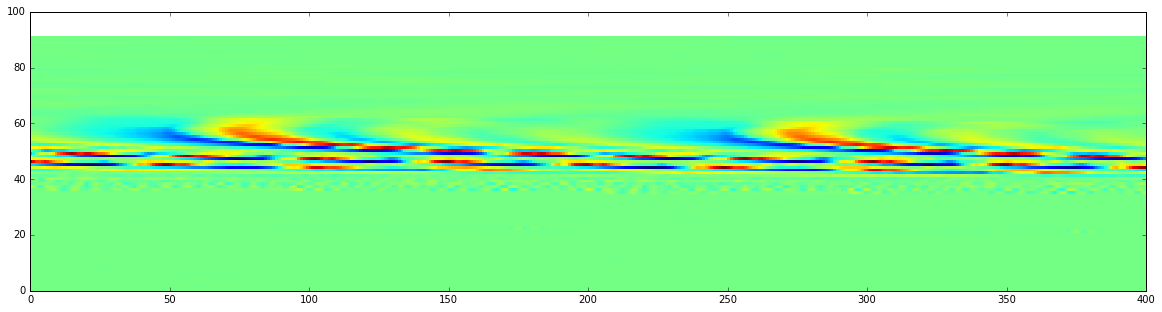

In [7]:
plt.figure(figsize=(20, 5))
#print(frames.shape) #(91,400)
pcolormesh(frames)

### Pre-emphasis

$y[n] = x[n] - p \, x[n-1]$ [time domain]

$Y(z) = X(z) - p \, X(z) \, z^{-1}$ [freq. domain]

So, the system response is the following

\begin{equation} H(z) = \frac{Y(z)}{X(z)} = 1 - p \, z^{-1} = \frac{z-p}{z}\end{equation}

The corresponding filter is `signal.lfilter([1,-p],[1],input,axis=1)`, and equivant to a high-pass filter below

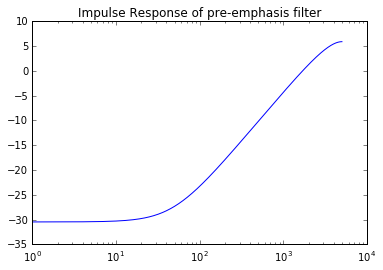

In [8]:
plt.title("Impulse Response of pre-emphasis filter")
plt.semilogx(20*np.log10(np.abs(rfft(signal.lfilter([1,-PREEMCOEFF],[1],signal.unit_impulse(10000,'mid'))))))

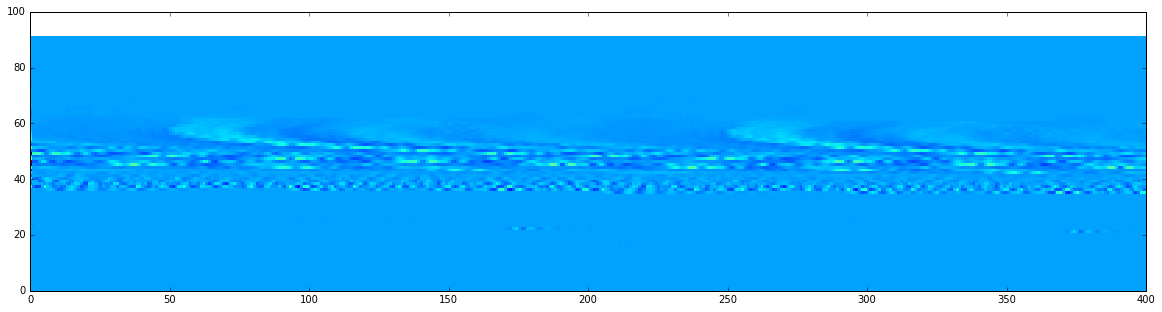

In [9]:
plt.figure(figsize=(20, 5))
pcolormesh(preemph)

We can see that the magnitude decrease, but the distribution seems alike as previous

In [9]:
Audio(example['samples'],rate=SAMPLING_RATE)

In [10]:
Audio(signal.lfilter([1,-PREEMCOEFF],[1],example['samples']),rate=SAMPLING_RATE)  ## More clear!

### Hamming Window

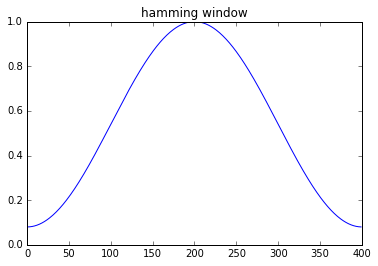

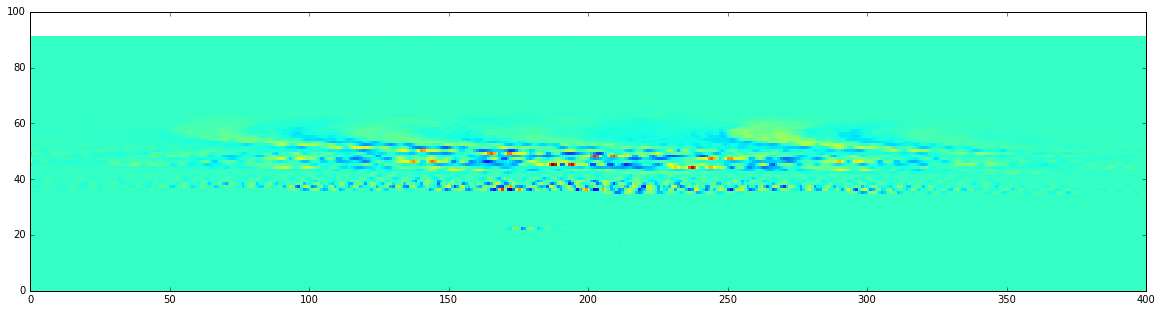

In [10]:
ham_window = signal.hamming(preemph.shape[1],sym=False)
plt.title('hamming window')
plot(ham_window)
plt.figure(figsize=(20, 5))
pcolormesh(windowed)

When we do FFT on finite signal (in the next step), it implicitly applied to infite repeated signal,

so if the start and end value doesn't match (which is probable), it will cause **discontinuity** in time domain, and the corresponding spectrum will contain lots of undesired component (especially in high freq) -> see discussion section in the end

### Fast Fourier Transform

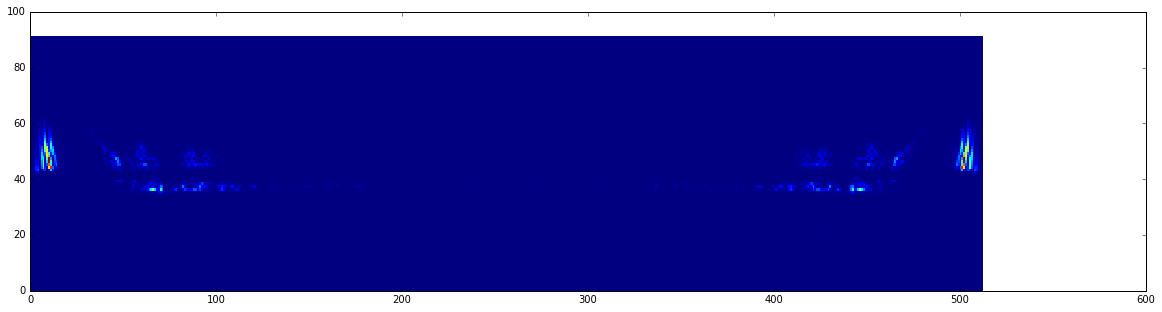

In [11]:
plt.figure(figsize=(20, 5))
pcolormesh(spec)

Base on Sampling Theorem, $f_M = \frac{f_s}{2}$ , so $f_M$ is $10$ kHz

Because our signal is real, so the corresponding freq will contain both positive and negative ones, and they are identical, but we only maintain positive one

### Mel filterbank log spectrum

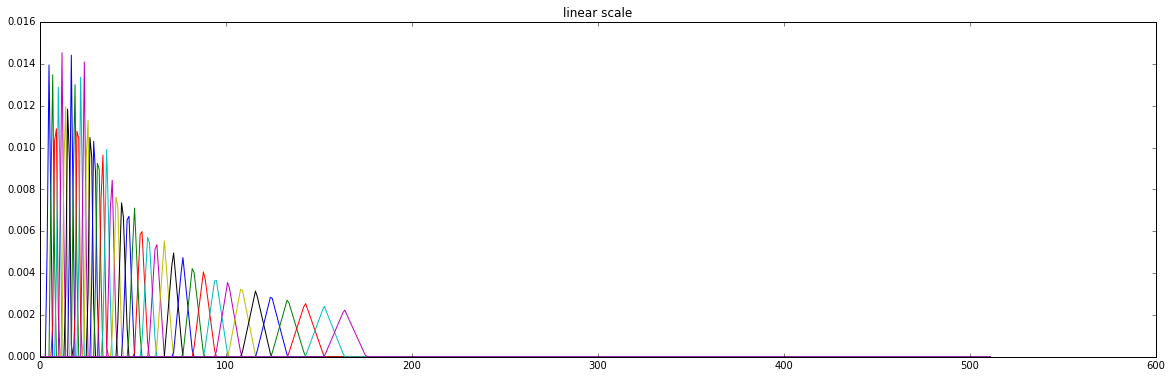

In [12]:
plt.figure(figsize=(20, 6))
filter_banks = trfbank(SAMPLING_RATE,spec.shape[1])
plt.title('linear scale')
for f in filter_banks:
    plot(f)

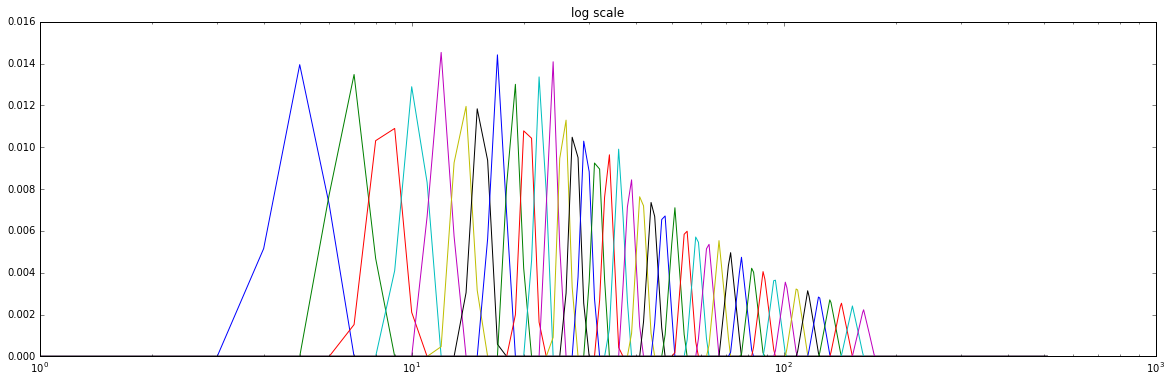

In [13]:
plt.figure(figsize=(20, 6))
plt.title('log scale')
plt.xscale('log')
#plt.semilogx(filter_banks.shape[1])
for f in filter_banks:
    plot(f)

The filter distributed logarithmically in frequency axis.

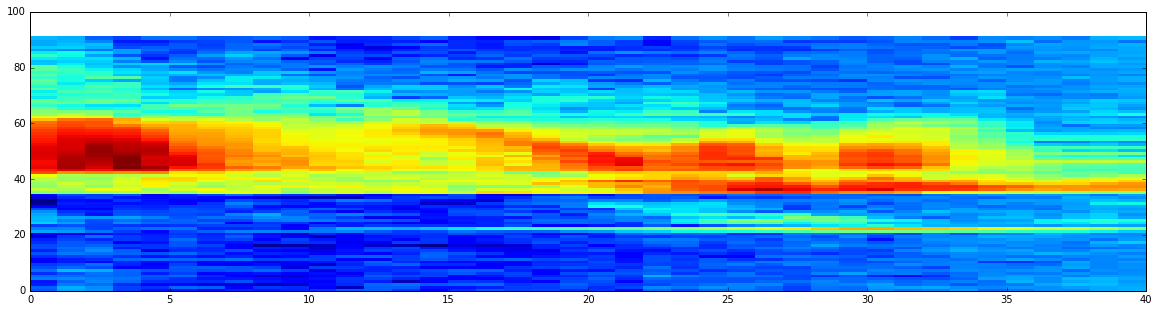

In [14]:
plt.figure(figsize=(20, 5))
pcolormesh(mspec)

### Cosine Transform and Liftering

#### MFCC

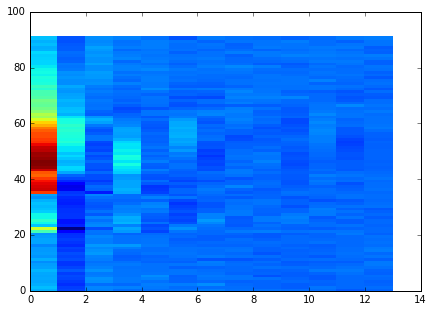

In [15]:
plt.figure(figsize=(7, 5))
pcolormesh(ceps)

#### Lifted MFCC

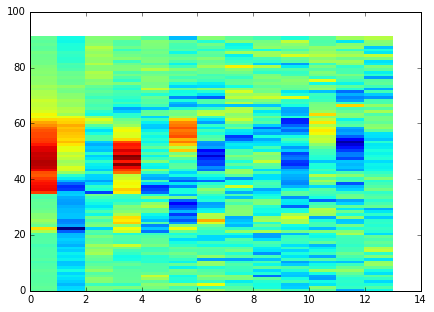

In [16]:
plt.figure(figsize=(7, 5))
pcolormesh(lifted_ceps)

## Discussions & Questions

If we just use rectangular window instead of hamming window, the corresponding mel spectrum will be the following, but I cannot see so much difference between them...

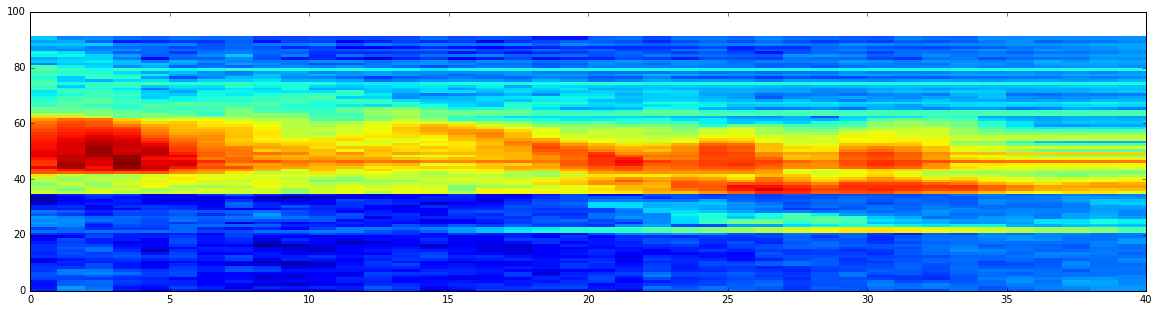

In [73]:
plt.figure(figsize=(20, 5))
pcolormesh(logMelSpectrum(powerSpectrum(preemph,NFFT),SAMPLING_RATE))

**Difference in mel spectrums between these two windowing method**

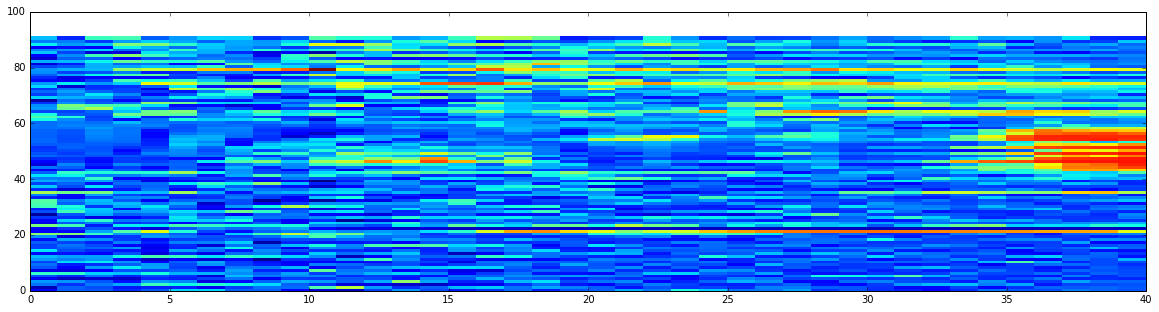

In [17]:
plt.figure(figsize=(20, 5))
pcolormesh(logMelSpectrum(powerSpectrum(preemph,NFFT),SAMPLING_RATE) - mspec)

You can see that the high frequnecy part have relatively large difference.